In [1]:
# Link ASSET
#https://drive.google.com/drive/folders/10nscMf90rtMeY6wcFsrH6HnAepX7Azbd?usp=sharing

# Libraries

In [2]:
# Import Libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.io import imread
import pandas as pd
import os
import glob
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [3]:
!pip install ipython-autotime

%load_ext autotime

time: 210 µs (started: 2021-12-05 14:56:23 +00:00)


# Retrieving Assets

In [4]:
# Clone asset dari github
!git clone https://github.com/Theofilusarifin/DIP_Project_Asset.git

Cloning into 'DIP_Project_Asset'...
remote: Enumerating objects: 1116, done.
remote: Counting objects: 100% (1116/1116), done.
remote: Compressing objects: 100% (1110/1110), done.
remote: Total 1116 (delta 3), reused 1115 (delta 2), pack-reused 0
Receiving objects: 100% (1116/1116), 85.28 MiB | 36.80 MiB/s, done.
Resolving deltas: 100% (3/3), done.
time: 4.05 s (started: 2021-12-05 14:56:23 +00:00)


#Define Label and Store image for each label

In [5]:
# Go to dataset directories (Samakan Tempatnya)
%cd DIP_Project_Asset/dataset

/content/DIP_Project_Asset/dataset
time: 7.87 ms (started: 2021-12-05 14:56:27 +00:00)


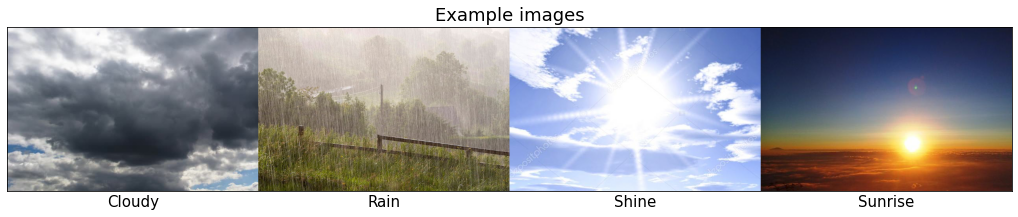

time: 2.86 s (started: 2021-12-05 14:56:27 +00:00)


In [6]:
from keras.preprocessing import image
from PIL import Image, ImageDraw, ImageFont

# Menampilkan Contoh Gambar

cloudy_img = Image.open('Cloudy/cloudy18.jpg')
rain_img = Image.open('Rain/rain24.jpg')
shine_img = Image.open('Shine/shine18.jpg')
sunrise_img = Image.open('Sunrise/sunrise3.jpg')
example_imgs = [cloudy_img, rain_img, shine_img, sunrise_img]

w, h = example_imgs[1].size
grid = Image.new('RGBA', size=(4*w, h))
grid_w, grid_h = grid.size
ls = grid_w/4   # label spacing

for i, img in enumerate(example_imgs):
    grid.paste(img, box=(i%4*w, i//4*h))

plt.figure(figsize=(18,10))
plt.title('Example images', fontsize=18)
plt.imshow(grid)
plt.xticks([ls-ls/2, ls*2-ls/2, ls*3-ls/2, ls*4-ls/2], ('Cloudy', 'Rain', 'Shine', 'Sunrise'), fontsize=15)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.yticks([])
plt.show()

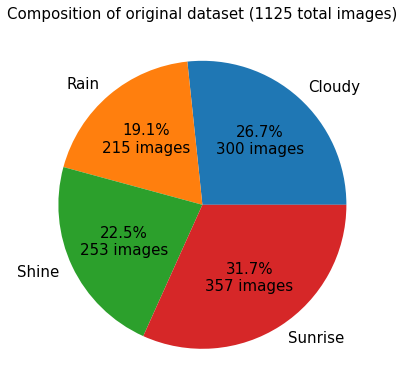

time: 168 ms (started: 2021-12-05 14:56:30 +00:00)


In [7]:
# Plot distribution of classes
def label_pie(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n{:d} images".format(pct, absolute)

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
base_dir = '/content/DIP_Project_Asset/'
dataset_dir = os.path.join(base_dir, 'dataset')
cloudy_dir = os.path.join(dataset_dir, 'Cloudy/')
rain_dir = os.path.join(dataset_dir, 'Rain/')
shine_dir = os.path.join(dataset_dir, 'Shine/')
sunrise_dir = os.path.join(dataset_dir, 'Sunrise/')
weather_conditions = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
num_images = [len(os.listdir(cloudy_dir)),len(os.listdir(rain_dir)),len(os.listdir(shine_dir)),len(os.listdir(sunrise_dir))]
ax.pie(num_images, labels = weather_conditions, autopct=lambda pct: label_pie(pct, num_images), textprops={'fontsize': 15})
plt.title('Composition of original dataset ({} total images)'.format(sum(num_images)), fontsize=15)
plt.show()

In [8]:
# Get the image file list
# The folder represent the label of image

# Membaca list yang ada di data set supaya kita bisa baca labelnya ada berapa
directories = os.listdir()
print(directories)

filename = [] #Nama filenya
label = [] #Nama label

for i in range(0, len(directories)):
  os.chdir(directories[i])
  files = os.listdir() #Mendapatkan list nama file di folder label
  for j in range(0, len(files)):
    files[j] = directories[i] + "/" + files[j] #Sebelum nama file ditambah nama directorinya
    label.append(i)
  filename = filename + files
  os.chdir(os.path.dirname(os.getcwd())) #supaya kembali ke dir awal (balik satu level)
print(filename)
print(label)

['Rain', 'Shine', 'Cloudy', 'Sunrise']
['Rain/rain115.jpg', 'Rain/rain212.jpg', 'Rain/rain143.jpg', 'Rain/rain71.jpg', 'Rain/rain134.jpg', 'Rain/rain149.jpg', 'Rain/rain153.jpg', 'Rain/rain203.jpg', 'Rain/rain97.jpg', 'Rain/rain174.jpg', 'Rain/rain206.jpg', 'Rain/rain54.jpg', 'Rain/rain5.jpg', 'Rain/rain31.jpg', 'Rain/rain169.jpg', 'Rain/rain181.jpg', 'Rain/rain147.jpg', 'Rain/rain196.jpg', 'Rain/rain210.jpg', 'Rain/rain48.jpg', 'Rain/rain190.jpg', 'Rain/rain211.jpg', 'Rain/rain142.jpg', 'Rain/rain11.jpg', 'Rain/rain61.jpg', 'Rain/rain64.jpg', 'Rain/rain105.jpg', 'Rain/rain40.jpg', 'Rain/rain18.jpg', 'Rain/rain191.jpg', 'Rain/rain209.jpg', 'Rain/rain89.jpg', 'Rain/rain157.jpg', 'Rain/rain214.jpg', 'Rain/rain92.jpg', 'Rain/rain113.jpg', 'Rain/rain135.jpg', 'Rain/rain164.jpg', 'Rain/rain197.jpg', 'Rain/rain202.jpg', 'Rain/rain82.jpg', 'Rain/rain161.jpg', 'Rain/rain183.jpg', 'Rain/rain185.jpg', 'Rain/rain111.jpg', 'Rain/rain32.jpg', 'Rain/rain90.jpg', 'Rain/rain141.jpg', 'Rain/rain170.jpg

In [9]:
# Save Image list directory to pandas dataframe

#Untuk menyimpan lokasi
data = {"filename": filename,
        "label": label
        }
data = pd.DataFrame(data = data)

dataset = data.sample(frac = 1) #Data Disuffle supaay tidak urut

dataset

,filename,label
211,Rain/rain69.jpg,0
140,Rain/rain19.jpg,0
1039,Sunrise/sunrise5.jpg,3
770,Sunrise/sunrise48.jpg,3
476,Cloudy/cloudy74.jpg,2
...,...,...
875,Sunrise/sunrise292.jpg,3
340,Shine/shine58.jpg,1
704,Cloudy/cloudy165.jpg,2
44,Rain/rain111.jpg,0


time: 39.5 ms (started: 2021-12-05 14:56:30 +00:00)


#Preprocessing

In [10]:
#Preprocess the image such as smoothing. sharpening, resize, reshape and convert the image to numpy

def load_image_files(train_data):
  images = []
  Y = []
  #membaca tiap data row di data set dan membaca kolom ke 0 yaitu filename
  for obj in train_data.values:
    img_pred = cv.imread(obj[0])
    # PROCESS PREPROCESSING
    try:
      img_pred = cv.GaussianBlur(img_pred,(5,5),0) #Smoothing
      kernel = np.array([[0,-1,0], #Kernel Sharpening
                         [-1,5,-1],
                         [0,-1,0]])
      img_pred = cv.filter2D(img_pred, -1, kernel) #Sharpening
      img_pred = cv.resize(img_pred, (128,128), interpolation = cv.INTER_AREA) #Ada yang lebih kecil atau lebih besar dari 128x128 akan di resize ke 128x128
      img_pred = image.img_to_array(img_pred)
      img_pred = img_pred / 255 #Di rescale
    except:
      continue
    # Ada 3 dimensi rgb, diubah jadi 1 dimensi vektor
    img_pred = img_pred.reshape(img_pred.shape[0]*img_pred.shape[1]*img_pred.shape[2])
    # Masukkan hasil ke images
    images.append(img_pred)
    Y.append(obj[1])
  X = np.array(images)
  Y = np.array(Y)
  return X, Y #Return gambar dan namanya

time: 21.9 ms (started: 2021-12-05 14:56:30 +00:00)


In [11]:
from sklearn.model_selection import train_test_split

# Split to training and testing data
X, y = load_image_files(dataset)
print("data shape", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 15, test_size = 0.3) #test size = 30% untuk testing, 70% untuk training

print("X_train: ", X_train.shape) #70% dari data shape
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape) #30% dari data shape
print("y_test: ", y_test.shape)

data shape (1123, 49152)
X_train:  (786, 49152)
y_train:  (786,)
X_test:  (337, 49152)
y_test:  (337,)
time: 13.3 s (started: 2021-12-05 14:56:30 +00:00)


#K-Fold Cross Validation

CV yang digunakan adalah 5. Apabila CV terlalu besar maka testset menjadi terlalu sedikit. Apabila CV terlalu kecil maka trainset akan menjadi terlalu sedikit

In [12]:
!pip install luwiji

     |████████████████████████████████| 40.3 MB 1.6 MB/s 
     |████████████████████████████████| 100 kB 8.6 MB/s 
  Created wheel for luwiji: filename=luwiji-1.1.8-py2.py3-none-any.whl size=40371111 sha256=e1cf928b8433bcf5a209d2caacf063d99ab320e5b008fc4b47832c9c7bda4393
  Stored in directory: /root/.cache/pip/wheels/5f/a8/96/3325d6d0da9d54645c9b6d87b35585b48c59aca8b6e16131aa
  Created wheel for jcopml: filename=jcopml-1.1.14-py2.py3-none-any.whl size=33655 sha256=5b9591eb0bf1ea12bc29a260a6dc6a428f4e3dac75df027bd407863ff0c171da
  Stored in directory: /root/.cache/pip/wheels/d9/6a/86/9a622c06f65732afe0e31c02a92fae6ab663ffd7162bcf5125
Successfully built luwiji jcopml
time: 12.9 s (started: 2021-12-05 14:56:43 +00:00)


Berikut merupakan illustrasi dari kfold yang kami gunakan

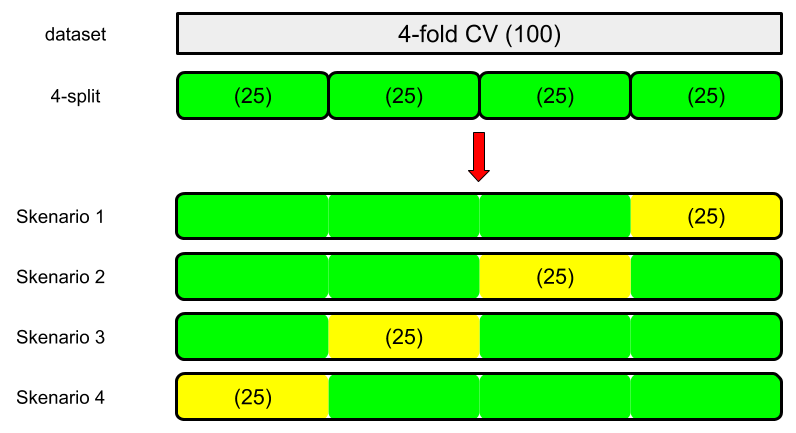

time: 291 ms (started: 2021-12-05 14:56:56 +00:00)


In [13]:
from luwiji.knn import illustration
from sklearn.model_selection import cross_val_score
illustration.kfold_cv

Secara default, Sklearn telah menggunakan StratifiedKFold agar data menjadi selang-seling seperti gambar dibawah ini

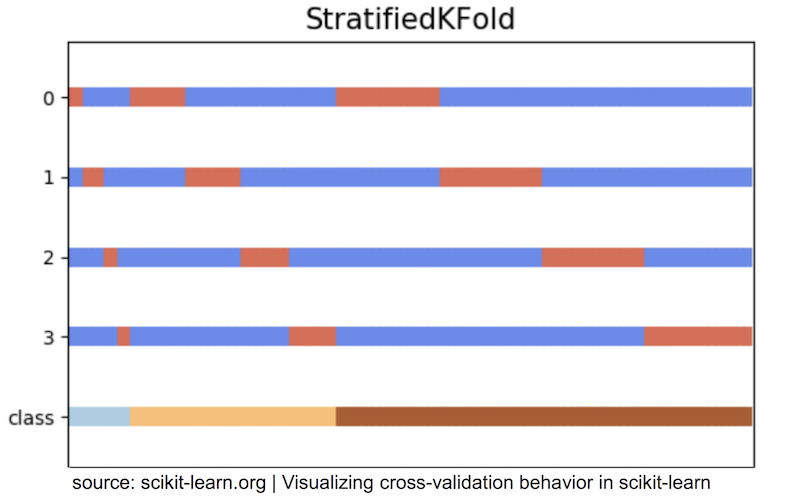

time: 7.95 ms (started: 2021-12-05 14:56:56 +00:00)


In [14]:
illustration.strat_kfold_cv

Berikut adalah hasil dari K-Fold Cross Validation dari tiap classifier yang kami gunakan

DT (Decision Tree)

In [15]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(max_depth=5) #build
dt_cvs = cross_val_score(dt, X, y, cv=5).mean()
print(dt_cvs)

0.7017063492063492
time: 1min 39s (started: 2021-12-05 14:56:56 +00:00)


RF (Random Forest)

In [16]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_cvs = cross_val_score(rf, X, y, cv=5).mean()
print(rf_cvs)

0.8531269841269842
time: 47.1 s (started: 2021-12-05 14:58:36 +00:00)


NB (Naive Bayes)

In [17]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb_cvs = cross_val_score(nb, X, y, cv=5).mean()
print(nb_cvs)

0.721297619047619
time: 3.05 s (started: 2021-12-05 14:59:23 +00:00)


KNN (K-Nearest Neighbor)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan') #0.8148214285714286
# knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean') #0.8058333333333334
# knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski') #0.8058333333333334
# knn = KNeighborsClassifier(n_neighbors=1, metric='chebyshev') #0.40519444444444447
knn_cvs = cross_val_score(knn, X, y, cv=5).mean()
print(knn_cvs)

0.816563492063492
time: 53.1 s (started: 2021-12-05 14:59:26 +00:00)


SVM (Support Vector Machine)

In [19]:
from sklearn import svm

svm = svm.SVC(kernel='rbf') #0.8584166666666666
# svm = svm.SVC(kernel='poly') #0.8539523809523809
# svm = svm.SVC(kernel='linear') #0.8468531746031746
# svm = svm.SVC(kernel='sigmoid') #0.22264285714285714

svm_cvs = cross_val_score(svm, X, y, cv=5).mean()
print(svm_cvs)

0.8575396825396826
time: 2min 45s (started: 2021-12-05 15:00:20 +00:00)


Dibawah ini merupakan tabel perbandingan hasil K-Fold Cross Validation tiap Classifier

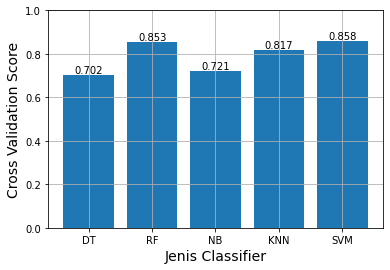

time: 218 ms (started: 2021-12-05 15:03:05 +00:00)


In [20]:
import matplotlib.pyplot as plt

# labels for bars
x = ['DT', 'RF', 'NB', 'KNN', 'SVM']

# heights of bars
y = [round(dt_cvs,3), round(rf_cvs,3), round(nb_cvs,3), round(knn_cvs,3), round(svm_cvs,3)]
 
# plotting a bar chart
plt.bar(x, y)

# add value labels
for i in range(len(x)):
  plt.text(i, y[i], y[i], ha="center", va="bottom")

# plot title
# plt.title('Perbandingan Cross Validation Score untuk tiap jenis Classifier', fontsize=14)
# naming the x-axis
plt.xlabel('Jenis Classifier', fontsize=14)
# naming the y-axis
plt.ylabel('Cross Validation Score', fontsize=14)

plt.ylim(0,1)

plt.grid(True)
# function to show the plot
plt.show()

K-Fold Cross Validation tidak digunakan pada CNN (Convolutional Neural Network) karena parameter dari CNN terlalu banyak. Training untuk CNN sudah memerlukan waktu yang cukup lama, melakukan K-Fold Cross Validation akan memakan waktu yang lebih lama lagi.

#DT (Decision Tree) Classifier

In [21]:
# from sklearn import tree
# dt = tree.DecisionTreeClassifier(max_depth=5) #build
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
CM = confusion_matrix(y_pred, y_test)
print(CM)

print("")

Accuracy Score:  0.6706231454005934
[[42  5 22  8]
 [ 3 56  5  3]
 [23 17 53 12]
 [ 3  0 10 75]]

time: 17.5 s (started: 2021-12-05 15:03:06 +00:00)


In [22]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))

Jumlah False Positive = 5
Jumlah False Negative = 3
Jumlah True Positive = 56
Jumlah True Negative = 42

Accuracy : 0.92
Precision : 0.92
Recall : 0.95
F1 Score : 0.47
time: 15.7 ms (started: 2021-12-05 15:03:23 +00:00)


#RF (Random Forest) Classifier

In [23]:
# from sklearn import ensemble
# rf = ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
CM = confusion_matrix(y_pred, y_test)
print(CM)
print("")

Accuracy Score:  0.8338278931750742
[[52  0  8  1]
 [ 1 69 10  0]
 [16  9 67  4]
 [ 2  0  5 93]]

time: 8.15 s (started: 2021-12-05 15:03:23 +00:00)


In [24]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))

Jumlah False Positive = 0
Jumlah False Negative = 1
Jumlah True Positive = 69
Jumlah True Negative = 52

Accuracy : 0.99
Precision : 1.0
Recall : 0.99
F1 Score : 0.5
time: 19.4 ms (started: 2021-12-05 15:03:31 +00:00)


#NB (Naive Bayes) Classifier

In [25]:
# from sklearn.naive_bayes import GaussianNB
# nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
CM = confusion_matrix(y_pred, y_test)
print(CM)

print("")

Accuracy Score:  0.7151335311572701
[[42  6 14  1]
 [10 66 15  1]
 [14  6 50 13]
 [ 5  0 11 83]]

time: 639 ms (started: 2021-12-05 15:03:31 +00:00)


In [26]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))

Jumlah False Positive = 6
Jumlah False Negative = 10
Jumlah True Positive = 66
Jumlah True Negative = 42

Accuracy : 0.87
Precision : 0.92
Recall : 0.87
F1 Score : 0.45
time: 19.7 ms (started: 2021-12-05 15:03:32 +00:00)


#KNN (K-Nearest Neighbor) Classifier

In [27]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
CM = confusion_matrix(y_pred, y_test)
print(CM)
print("")

Accuracy Score:  0.8189910979228486
[[52  4 12  3]
 [ 3 65  9  1]
 [15  7 66  1]
 [ 1  2  3 93]]

time: 13.8 s (started: 2021-12-05 15:03:32 +00:00)


In [28]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))

Jumlah False Positive = 4
Jumlah False Negative = 3
Jumlah True Positive = 65
Jumlah True Negative = 52

Accuracy : 0.94
Precision : 0.94
Recall : 0.96
F1 Score : 0.47
time: 13 ms (started: 2021-12-05 15:03:46 +00:00)


#SVM (Support Vector Machine) Classifier

In [29]:
# from sklearn import svm
# svm = svm.SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
CM = confusion_matrix(y_pred, y_test)
print(CM)
print("")

Accuracy Score:  0.8635014836795252
[[50  0  7  0]
 [ 3 74 10  0]
 [18  4 72  3]
 [ 0  0  1 95]]

time: 35.9 s (started: 2021-12-05 15:03:46 +00:00)


In [30]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))

Jumlah False Positive = 0
Jumlah False Negative = 3
Jumlah True Positive = 74
Jumlah True Negative = 50

Accuracy : 0.98
Precision : 1.0
Recall : 0.96
F1 Score : 0.49
time: 20.2 ms (started: 2021-12-05 15:04:22 +00:00)


#CNN (Convolutional Neural Network) Classifier


In [31]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

#build model
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))

cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

time: 356 ms (started: 2021-12-05 15:04:22 +00:00)


In [32]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

In [33]:
# Callback digunakan apabila akurasi sudah mencapai 99% walaupun iterasi belum selesai, iterasi akan dihentikan
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy')>0.999):
      print('\nAkurasi mencapai lebih dari 99%')
      self.model.stop_training = True

callbacks = myCallback()

time: 4.98 ms (started: 2021-12-05 15:04:22 +00:00)


In [34]:
#compile model
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#reshape train image
X_train_reshaped = X_train.reshape(X_train.shape[0], 128, 128, 3)

history = cnn.fit(X_train_reshaped, y_train, epochs=25, callbacks=[callbacks])

Epoch 1/25
25/25 [==============================] - 21s 791ms/step - loss: 1.2687 - accuracy: 0.5407
Epoch 2/25
25/25 [==============================] - 18s 718ms/step - loss: 0.7042 - accuracy: 0.7354
Epoch 3/25
25/25 [==============================] - 18s 720ms/step - loss: 0.5310 - accuracy: 0.7913
Epoch 4/25
25/25 [==============================] - 18s 718ms/step - loss: 0.4462 - accuracy: 0.8435
Epoch 5/25
25/25 [==============================] - 18s 716ms/step - loss: 0.3867 - accuracy: 0.8473
Epoch 6/25
25/25 [==============================] - 18s 716ms/step - loss: 0.3863 - accuracy: 0.8524
Epoch 7/25
25/25 [==============================] - 18s 717ms/step - loss: 0.2663 - accuracy: 0.9020
Epoch 8/25
25/25 [==============================] - 18s 719ms/step - loss: 0.2444 - accuracy: 0.9211
Epoch 9/25
25/25 [==============================] - 18s 729ms/step - loss: 0.2347 - accuracy: 0.8982
Epoch 10/25
25/25 [==============================] - 18s 724ms/step - loss: 0.1456 - accura

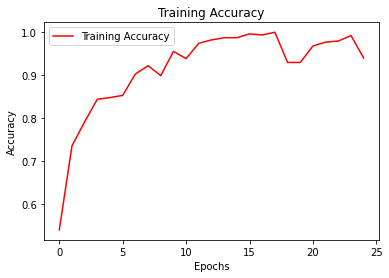

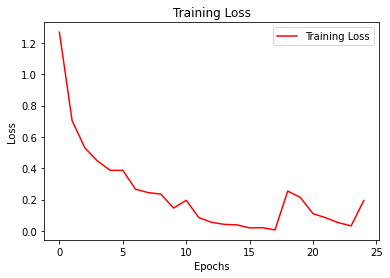

time: 358 ms (started: 2021-12-05 15:11:55 +00:00)


In [35]:
# Melihat akurasi dan juga loss model dari segi grafik
%matplotlib inline

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

In [36]:
#reshape test images
X_test_reshaped = X_test.reshape(X_test.shape[0], 128, 128, 3)

#Overall model accuracy
cnn.evaluate(X_test_reshaped, y_test)
print("")

11/11 [==============================] - 2s 187ms/step - loss: 0.6875 - accuracy: 0.7953

time: 3.03 s (started: 2021-12-05 15:11:55 +00:00)


#Load File Method 

In [37]:
#Untuk single files

def load_single_image_files(path):
  images = []
  img_pred = cv.imread(path)
  # PROCESS PREPROCESSING
  try:
    img_pred = cv.GaussianBlur(img_pred,(5,5),0)
    kernel = np.array([[0,-1,0],
                      [-1,5,-1],
                      [0,-1,0]])
    img_pred = cv.filter2D(img_pred, -1, kernel)
    img_pred = cv.resize(img_pred, (128,128), interpolation = cv.INTER_AREA) #Ada yang lebih kecil atau lebih besar dari 128x128 akan di resize ke 128x128
    img_pred = image.img_to_array(img_pred)
    img_pred = img_pred / 255 #Di rescale
  except:
    pass
  # Ada 3 dimensi rgb, diubah jadi 1 dimensi vektor
  img_pred = img_pred.reshape(img_pred.shape[0]*img_pred.shape[1]*img_pred.shape[2])
  # Masukkan hasil ke images
  images.append(img_pred)
  X = np.array(images)
  return X

time: 16.8 ms (started: 2021-12-05 15:11:58 +00:00)


In [38]:
os.chdir('/content')

time: 1.16 ms (started: 2021-12-05 15:11:58 +00:00)


#Testing

Saving sunrise3.jpg to sunrise3.jpg

Prediksi menggunakan DT (Decission Tree) Classifier
Sunrise

Prediksi menggunakan RF (Random Forest) Classifier
Sunrise

Prediksi menggunakan NB (Naive Bayes) Classifier
Sunrise

Prediksi menggunakan KNN (K-Nearest Neighbor) Classifier
Sunrise

Prediksi menggunakan SVM (Support Vector Machine) Classifier
Sunrise

Prediksi menggunakan CNN (Convolutional Neural Network) Classifier
Sunrise



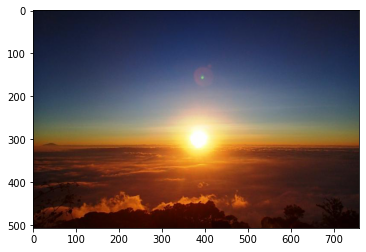

time: 12.6 s (started: 2021-12-05 15:11:58 +00:00)


In [39]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  #Predicting images
  path = fn

  X_single = load_single_image_files(path)

  img = image.load_img(path)
  imgplot = plt.imshow(img)

  print("")
  
  dt_pred_single = dt.predict(X_single)
  print("Prediksi menggunakan DT (Decission Tree) Classifier")
  print(directories[dt_pred_single[0]])

  print("")

  rf_pred_single = rf.predict(X_single)
  print("Prediksi menggunakan RF (Random Forest) Classifier")
  print(directories[rf_pred_single[0]])

  print("")

  nb_pred_single = nb.predict(X_single)
  print("Prediksi menggunakan NB (Naive Bayes) Classifier")
  print(directories[nb_pred_single[0]])

  print("")

  knn_pred_single = knn.predict(X_single)
  print("Prediksi menggunakan KNN (K-Nearest Neighbor) Classifier")
  print(directories[knn_pred_single[0]])

  print("")

  print("Prediksi menggunakan SVM (Support Vector Machine) Classifier")
  svm_pred_single = svm.predict(X_single)
  print(directories[svm_pred_single[0]])

  print("")

  X_single_reshaped = X_single.reshape(X_single.shape[0], 128, 128, 3)

  print("Prediksi menggunakan CNN (Convolutional Neural Network) Classifier")
  cnn_pred_single = cnn.predict(X_single_reshaped)
  y_class = [np.argmax(element) for element in cnn_pred_single]
  print(directories[y_class[0]])

  print("")